# Homework 3: Unsupervised Learning

**Give an overall summary of perfomance from Homework 2**

Prediction accuracy of the various learning algorithms employed in Homework 2 seemed to hover between 70% and 80%. While other measures of performance would likely demonstrate different and potentially better suited evaluations, I relied on prediction accuracy. 

I thus evaluated the best suited classifier on raw prediction accuracy, run-time, and interpretability. In terms of raw prediction accuracy, variability in the regard was rather muted, with the trained algorithms all providing prediction accuracy within the 75% range +/- 5%. Given the low variability, this led me to put a greater emphasis on interpretability, as the run-time in this example - while divergent across algorithms - was less a concern given the managable size of the dataset. With interpretability in mind, I chose a nearest neighbors algorithm fit with a smaller number of neighbors (relative to other tested parameters) as to compromise between acceptable accuracy, run-time, and easy understanding. 

**Do you see any areas for improvement?**

As noted throughout my submission for Homework 2, I saw potential areas of improvement in the realms of feature engineering as well as the employment of alternative measures of success - e.g. precision, recall. Utilizing clustering here will provide serious headway into the feature engineering, while I have also employed the alternative measures of prediction success below.

There are also potential improvements to be made by employing feature reduction, as several of the features symptomatic of being overweight appeared correlated in the previous homework.

**Run k-Means on the dataset and describe your results**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split, ShuffleSplit
from sklearn.metrics import silhouette_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
# Load data from URL
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data',
                    sep = ",", header = None)

colnames =  ['preg', 'plas', 'pres', 'skin', 'insu', 'mass', 'pedi', 'age', 'class']
data.columns = colnames
data.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
print data.shape
data.info()

(768, 9)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 767
Data columns (total 9 columns):
preg     768 non-null int64
plas     768 non-null int64
pres     768 non-null int64
skin     768 non-null int64
insu     768 non-null int64
mass     768 non-null float64
pedi     768 non-null float64
age      768 non-null int64
class    768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 60.0 KB


In [138]:
# UPDATE: removed due to error using categorical test variable in GNB
# convert class to a categorical
#data['class'] = pd.Categorical(data['class'])
#data.info()

In [4]:
data.describe()

,preg,plas,pres,skin,insu,mass,pedi,age,class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
# As in Homework 2, impute missing data with median values
medians = data.apply(lambda col: col.median(), axis=0)
data_clean = data.copy()

missing_col = ['plas', 'pres', 'skin', 'insu', 'mass']
for col in missing_col:
    filler = data[col].replace(0,medians[col])
    data_clean[col] = filler

In [6]:
data_clean.describe()

,preg,plas,pres,skin,insu,mass,pedi,age,class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,27.334635,94.652344,32.450911,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,9.229014,105.547598,6.875366,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,23.000000,30.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,31.250000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
# Separate data into independent and dependent variables
X, y = data_clean.drop(['class'], axis=1), data_clean['class']
X.columns = colnames[:len(colnames)-1]

In [26]:
# Transform independent variables to Gaussian
scale = StandardScaler()
X_std = pd.DataFrame(scale.fit_transform(X))

# Separate X, y into training and testing data with Shufflesplit
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.20, random_state=7)
X_train.columns = X_test.columns = X.columns

# Use Shufflesplit to cross-validate; choose 5 iterations
cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2)

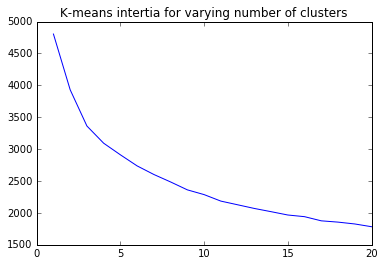

In [27]:
# Test kmeans for different number of cluster centers
index, inertia = [], []
for n in range(1,21):
    km = KMeans(n_clusters=n)
    km.fit(X_train)
    index.append(n)
    inertia.append(km.inertia_)
    
plt.plot(index,inertia)
plt.title('K-means intertia for varying number of clusters')

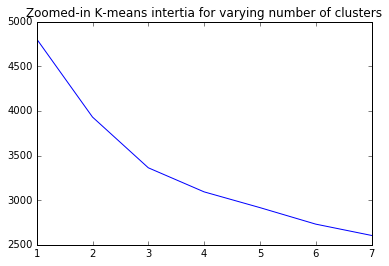

In [28]:
# Test kmeans for different number of cluster centers
index, inertia = [], []
for n in range(1,8):
    km = KMeans(n_clusters=n)
    km.fit(X_train)
    index.append(n)
    inertia.append(km.inertia_)
    
plt.plot(index,inertia)
plt.title('Zoomed-in K-means intertia for varying number of clusters')

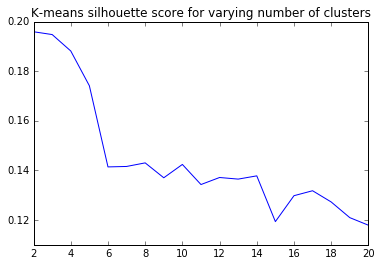

In [29]:
index, s_score = [], []
for n in range(2,21):
    km = KMeans(n_clusters=n)
    centers = km.fit_predict(X_train)
    index.append(n)
    s_score.append(silhouette_score(X_train, centers))
plt.plot(index, s_score)
plt.title('K-means silhouette score for varying number of clusters')

Based on heuristic "elbow method" applied to both the inertia and silhouette score charts above, choose 5 clusters, as this feels to be an inflection point.

In [30]:
%%time
km = KMeans(n_clusters=5, n_init=20)
km_train = km.fit(X_train)
cluster_labels = km_train.predict(X_train)

Wall time: 117 ms


In [31]:
# Run again not for time
km = KMeans(n_clusters=5, n_init=20)
km_train = km.fit(X_train)
cluster_labels = km_train.predict(X_train)

In [32]:
print 'Inertia of the k-means model with 5 clusters is %d.' % km_train.inertia_
print '\nSilhouette score of the k-means model with 5 clusters is {}.'.format(silhouette_score(X_train, cluster_labels))

Inertia of the k-means model with 5 clusters is 2911.

Silhouette score of the k-means model with 5 clusters is 0.173096067102.


In [37]:
#km.fit(X_train)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
columns = {str(x): scale.inverse_transform(km_train.cluster_centers_[x]) for x in range(0,len(km_train.cluster_centers_))}
clusters = pd.DataFrame(columns, index=X_train.columns)
clusters.index = X_train.columns
clusters

,0,1,2,3,4
preg,2.367,4.415,1.867,7.239,2.000
plas,105.101,160.098,141.400,130.461,117.524
pres,66.115,71.220,76.533,77.656,73.131
skin,21.014,33.146,40.300,26.328,33.828
insu,63.472,357.537,134.917,60.786,86.900
mass,27.109,36.117,40.133,32.493,38.381
pedi,0.399,0.441,1.318,0.434,0.431
age,25.968,33.829,34.100,45.289,27.338


In [38]:
data_clean.describe().T.drop('class', axis=0)

,count,mean,std,min,25%,50%,75%,max
preg,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
plas,768.000,121.656,30.438,44.000,99.750,117.000,140.250,199.000
pres,768.000,72.387,12.097,24.000,64.000,72.000,80.000,122.000
skin,768.000,27.335,9.229,7.000,23.000,23.000,32.000,99.000
insu,768.000,94.652,105.548,14.000,30.500,31.250,127.250,846.000
mass,768.000,32.451,6.875,18.200,27.500,32.000,36.600,67.100
pedi,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000


In [39]:
# Assess data with clusters
cluster_check = pd.concat([pd.Series(cluster_labels), pd.Series(y_train)],axis=1,join='inner')
cluster_check.columns = ['clusters','class']
cluster_check['clusters'].value_counts()

0    183
3    145
4    107
1     29
2     27
Name: clusters, dtype: int64

In [40]:
percentages = []
for cls in range(len(cluster_check['clusters'].value_counts())):
    percentages.append(float(sum(cluster_check[cluster_check['clusters']==cls]['class']))/len(cluster_check))
    
print pd.DataFrame(percentages).describe()
perc = pd.DataFrame(percentages)
perc.index=range(1,6)
perc

          0
count 5.000
mean  0.068
std   0.048
min   0.018
25%   0.022
50%   0.079
75%   0.086
max   0.134


,0
1,0.134
2,0.022
3,0.018
4,0.086
5,0.079


Assessing the 5 clusters, we begin to observe distinct groups in the population of Native American women. See below (note these are subject to reordering of the cluster matrix):

**Cluster 1: "Healthy Young Mommas"**

- members of this cohort are ths skinniest of the group, with BMI, skin fold thickness, and blood pressure all exhibiting the lowest levels of any cluster and falling near the bottom quartile
- women exhibit a roughly average number of pregnancies

**Cluster 2: "Stressed Out Fat Mommas"**

- constituents tend to have more kids than the average, while also being generally overweight, with skin fold thickness and BMI hovering near the upper quartile range
- the primary differentiator in this cluster is blood insulin levels which well into the top decile

**Cluster 3: "Genetically Predisposed Mommas"**

- members of this cohort appear to be generally overweight, with BMI and skin fold thickness near the top quartile mark
- the key differentiator is the diabetes pedigree function, where members of this cluster have a pedigree level almost 2 SD above the 75th percentile

**Cluster 4: "Old Baby Machines"**

- constituents fall in the upper quartile range with respect to both age and number of pregnancies
- this cohort is also notable for the highest blood pressure among the clusters 
- all other variables appear to imply these individuals are near the averages

**Cluster 5: "Young [Likely Single] Fatties"**

- constituents tend to be young and have had the fewest average pregnancies among the clusters, falling just above the lowest quartile boundary
- the grouping is defined by the highest average BMI and skin fold thickness, both falling into the upper quartile


Though more granularity in clusters may in practice provide additional predictive power, I've maintained a smaller number to better understand the demographic breakdown of the population. Without speaking to additive predictive power, the clusters help to see the beginning of a trend across a number of variables. 

Assessing likelihood of diabetes by cluster, we observe intuitive trends. Members of the cluster "Young Fatties" in the training data experience a likelihood of diabetes almost a full standard deviation above the average, while the instance of diabetes in the "Healthy Young Mommas" cluster fell significantly below the average. Also intuitively, women in the cohort "Old Baby Machines" experienced the highest rate of diabetes in the training set - around 12% - likely resulting from high blood pressure and age. 

**Run PCA on the dataset and describe results**

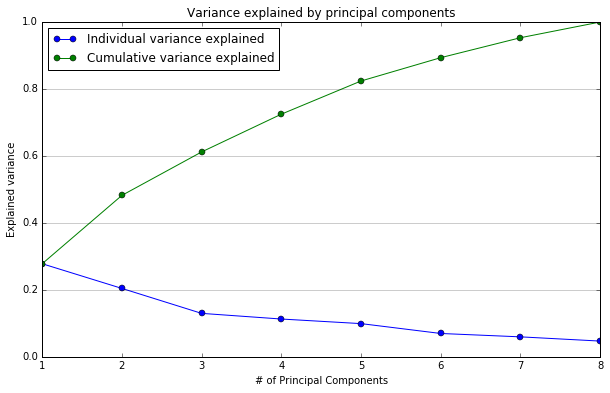

In [41]:
# Begin with 8 components as the Native American dataset consists of 8 predictive variables
pca = PCA(n_components=8, whiten=True)
pca.fit(X_train)
plt.figure(figsize=(10,6))
plt.plot(range(1,9), pca.explained_variance_ratio_, 'o-',
        label='Individual variance explained')
plt.plot(range(1,9), np.cumsum(pca.explained_variance_ratio_),'o-',
        label='Cumulative variance explained')
for i in np.linspace(.2,.8,4):
    plt.plot(range(1,9), [i]*8, color='k', alpha=0.2)
plt.title('Variance explained by principal components')
plt.ylabel('Explained variance')
plt.xlabel('# of Principal Components')
plt.legend(loc="best")

In [42]:
np.cumsum(pca.explained_variance_ratio_)

array([ 0.27793934,  0.48217221,  0.61189363,  0.72471662,  0.82382295,
        0.89348175,  0.95305804,  1.        ])

As the first 6 principal components explain almost 90% of the variance in the dataset, continue using the first 6 principal components and find correlation between these and the original features.

In [43]:
pca = PCA(n_components=6, whiten=True)
pca_train = pca.fit(X_train)
pcs_train = pd.DataFrame(pca_train.transform(X_train))

In [44]:
pcs_train.columns = ['PC1','PC2','PC3','PC4','PC5','PC6']
pcs_train.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-0.525,-0.243,1.046,0.144,-1.458,-0.245
1,-0.675,-0.924,2.142,-0.800,-0.258,0.837
2,-0.351,0.117,-0.503,0.240,1.574,-0.918
3,0.382,-0.137,0.941,-0.452,-0.188,-0.293
4,-0.136,-1.083,-0.504,0.293,-0.136,-0.073


In [45]:
# Confirm .fit_transform() is the same as .fit() -> .transform()
pcs2 = pd.DataFrame(pca.fit_transform(X_train))
pcs2.columns = pcs_train.columns
pcs2.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-0.525,-0.243,1.046,0.144,-1.458,-0.245
1,-0.675,-0.924,2.142,-0.800,-0.258,0.837
2,-0.351,0.117,-0.503,0.240,1.574,-0.918
3,0.382,-0.137,0.941,-0.452,-0.188,-0.293
4,-0.136,-1.083,-0.504,0.293,-0.136,-0.073


In [46]:
# Assess how to join the principal component and train data
print pcs_train.shape
print X_train.shape

(614, 6)
(614, 8)


In [47]:
X_train.head()

,preg,plas,pres,skin,insu,mass,pedi,age
289,0.343,-0.449,-0.032,1.699,-0.186,0.531,-0.631,-0.020
328,-0.548,-0.646,1.126,0.940,0.240,1.899,-1.042,-0.871
394,0.046,1.195,0.464,-0.470,-0.608,0.065,1.000,-0.191
321,-0.251,-0.317,0.133,0.289,-0.608,-0.124,-0.830,-0.701
326,-0.845,0.011,-0.694,0.506,0.582,0.386,0.665,-0.276


Observe the unordered indices of X_train. Reset indices for easier concatenation.

In [48]:
# Remove index of training data for easier concatenation
X_train = X_train.reset_index(drop=True)
X_train.head()

,preg,plas,pres,skin,insu,mass,pedi,age
0,0.343,-0.449,-0.032,1.699,-0.186,0.531,-0.631,-0.020
1,-0.548,-0.646,1.126,0.940,0.240,1.899,-1.042,-0.871
2,0.046,1.195,0.464,-0.470,-0.608,0.065,1.000,-0.191
3,-0.251,-0.317,0.133,0.289,-0.608,-0.124,-0.830,-0.701
4,-0.845,0.011,-0.694,0.506,0.582,0.386,0.665,-0.276


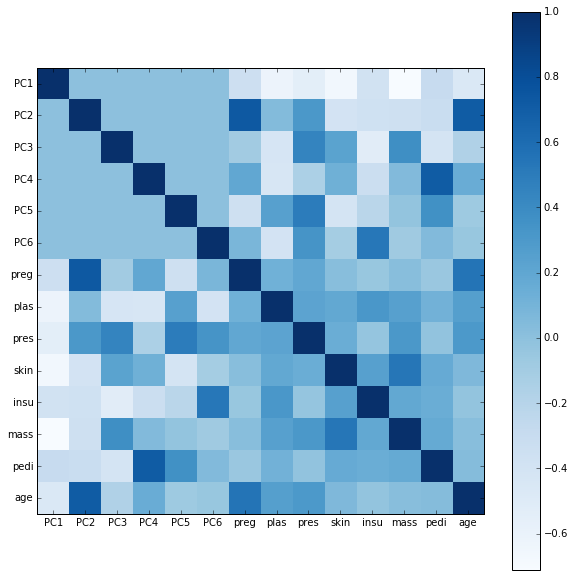

In [49]:
# Create correlation matrix for principal components and variables
# pcs_train.index = X_train.index
corrmat = pd.concat([pcs_train,X_train],axis=1,join='inner').corr()

labels = ['PC1','PC2','PC3','PC4','PC5','PC6',
         'preg', 'plas', 'pres', 'skin', 'insu', 'mass', 'pedi', 'age']
column_labels = row_labels = labels

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
plt.imshow(corrmat, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

ax.set_xticks(np.arange(corrmat.shape[0]), minor=False)
ax.set_yticks(np.arange(corrmat.shape[1]), minor=False)
ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(column_labels, minor=False)

plt.show()

Applying principal component analysis yields potentially significant gains in computational speed as we can retain 90% of the variance in the data while compressing the training data by 25%, from 8 column variables to 6. 

While this may yield efficiency gains further down the model pipeline, this will reduce explainability of the model as we see few obvious linear relationships (read correlations) between the principal components and the original prediction variables.

**Use the cluster outputs you got from running k-means as a new feature. Rerun your "worst" and "best" model from HW2, including this new feature along with your old features. Describe your results.**

In [50]:
# Add clusters to existing X_train dataframe
X_train_cls = X_train.copy()
X_train_cls['clstr'] = pd.Series(cluster_labels)
X_train_cls.head()

,preg,plas,pres,skin,insu,mass,pedi,age,clstr
0,0.343,-0.449,-0.032,1.699,-0.186,0.531,-0.631,-0.020,4
1,-0.548,-0.646,1.126,0.940,0.240,1.899,-1.042,-0.871,4
2,0.046,1.195,0.464,-0.470,-0.608,0.065,1.000,-0.191,3
3,-0.251,-0.317,0.133,0.289,-0.608,-0.124,-0.830,-0.701,4
4,-0.845,0.011,-0.694,0.506,0.582,0.386,0.665,-0.276,4


In [51]:
X_test_cls = X_test.copy()
X_test_cls['clstr'] = km_train.predict(X_test)
X_test_cls.head()

,preg,plas,pres,skin,insu,mass,pedi,age,clstr
353,-0.845,-1.041,-0.859,-1.663,-0.490,-0.764,0.327,-0.786,0
236,0.937,1.951,0.961,-0.687,0.923,0.502,0.345,1.511,3
323,2.719,0.998,1.457,0.614,-0.622,-0.822,0.783,0.830,3
98,0.640,-0.942,-1.852,0.289,-0.291,-0.546,-0.350,-0.871,0
701,0.640,0.110,0.464,0.397,-0.608,-0.706,0.281,1.341,3


Test kNN using 11 neighbors as "best" model from Homework 2 with the same GridSearch-ed parameters.

In [52]:
%%%timeit
# Initialize chosen "best model" from Homework 2 with and without clusters
knn_orig = KNeighborsClassifier(n_neighbors=11, weights='uniform', p=1)
knn_orig.fit(X_train, y_train)
knn_orig.predict(X_test)

100 loops, best of 3: 3.99 ms per loop


In [53]:
knn_orig = KNeighborsClassifier(n_neighbors=11, weights='uniform', p=1)
knn_orig.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=1,
           weights='uniform')

In [54]:
%%%timeit
# Initialize the knn with the cluster-augmented data
knn = KNeighborsClassifier(n_neighbors=11, weights='uniform', p=1)
knn.fit(X_train_cls, y_train)
knn.predict(X_test_cls)

100 loops, best of 3: 4.25 ms per loop


In [55]:
knn = KNeighborsClassifier(n_neighbors=11, weights='uniform', p=1)
knn.fit(X_train_cls, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=1,
           weights='uniform')

Oserve the marginal speed loss for the additional feature.

Find predicted cluster centers of the X_test data before assessing performance.

In [56]:
print "Prediction accuracy of original kNN model with 11 neighbors = %.2f%%" % (
    knn_orig.score(X_test, y_test)*100)

print "Prediction accuracy of 11 neighbor kNN model augmented with cluster labels = %.2f%%" % (
    knn.score(X_test_cls, y_test)*100)

Prediction accuracy of original kNN model with 11 neighbors = 77.27%
Prediction accuracy of 11 neighbor kNN model augmented with cluster labels = 75.32%


Using the cluster centers does not add tremendously to the predictive accuracy of the nearest neighbors model employed in project 2.

In [57]:
# Assess other metrics of performance
y_pred_orig = knn_orig.predict(X_test)
y_pred = knn.predict(X_test_cls)

precision_recall_fscore_support(y_test, y_pred, average='binary')    

print "Original kNN model:\nPrecision = %.2f%%, recall = %.2f%%, f1 score = %.2f%%." % (
        precision_recall_fscore_support(y_pred_orig, y_test, average='binary')[0]*100,
        precision_recall_fscore_support(y_pred_orig, y_test, average='binary')[1]*100,
        precision_recall_fscore_support(y_pred_orig, y_test, average='binary')[2]*100)

print "\nClustered kNN model:\nPrecision = %.2f%%, recall = %.2f%%, f1 score = %.2f%%." % (
        precision_recall_fscore_support(y_pred, y_test, average='binary')[0]*100,
        precision_recall_fscore_support(y_pred, y_test, average='binary')[1]*100,
        precision_recall_fscore_support(y_pred, y_test, average='binary')[2]*100)

Original kNN model:
Precision = 56.14%, recall = 76.19%, f1 score = 64.65%.

Clustered kNN model:
Precision = 52.63%, recall = 73.17%, f1 score = 61.22%.


Adding the cluster variable does appear, however, to have notable effect on precision and while leaving recall largely unchanged and therfore f1 score. ***It is important to note that, when running the same analysis with a 75/25 split rather than 80/20, adding the cluster variable actually diminished performance in regard to prediction accuracy and recall/f1 sore.*** This may result from having too few samples in each cluster.

Now try reapplying the GridSearch.

In [82]:
knn = KNeighborsClassifier()
parameters = {'n_neighbors': range(1,20), 'weights': ['uniform', 'distance'],
             'p': range(1,3)}
clf = GridSearchCV(knn, parameters, cv=cv)

clf.fit(X_train_cls, y_train)
best_knn = clf.best_estimator_

print clf.best_params_

{'n_neighbors': 12, 'weights': 'distance', 'p': 2}


In [83]:
# Compare accuracy of the models
y_pred_test = None
y_pred_test = best_knn.predict(X_test_cls)
print "Prediction accuracy of the new kNN model with %d neighbors = %.2f%%," % (
    pd.Series(clf.best_params_)[0], best_knn.score(X_test_cls, y_test)*100)
print "while we observe precision = %.2f%%, recall = %.2f%% and f1 score = %.2f%%." % (
        precision_recall_fscore_support(y_pred_test, y_test, average='binary')[0]*100,
        precision_recall_fscore_support(y_pred_test, y_test, average='binary')[1]*100,
        precision_recall_fscore_support(y_pred_test, y_test, average='binary')[2]*100)

Prediction accuracy of the new kNN model with 12 neighbors = 75.32%,
while we observe precision = 52.63%, recall = 73.17% and f1 score = 61.22%.


***The effect of the cluster variable seems largely dependent on the sampling. While running the analysis will sometimes show the cluster variable adversely affecting performance by most metrics, other samplings will show the cluster variable sharply improving recall or precision.***

In my first analysis, adding the cluster recall at the expense of precision, with a marginal increase in the f1 score. While not a definite improvement, the directional gains are alligned with our objectives, as it would seem more prudent to allow a greater type 1 error over type 2 error - i.e. false positives (false diabetes diagnosis) are better than false negatives (leaving patients untreated).

Test Gaussian Naive Bayes model as "worst" model from Homework 2.

*Note: precision_recall_fscore of the Homework 2 GNB model was (0.657, 0.657, 0.657).*

In [60]:
# Initialize Gaussian NB
from sklearn.naive_bayes import GaussianNB
gnb_orig = GaussianNB()
gnb = GaussianNB()

In [61]:
%%%timeit
gnb = GaussianNB()
nb = gnb.fit(X_train_cls, y_train)
y_pred_train = nb.predict(X_test_cls)
y_pred_test = nb.predict(X_test_cls)

1000 loops, best of 3: 1.11 ms per loop


In [62]:
X_test.shape

(154, 8)

In [63]:
# Initialize models
nb_orig_model = gnb_orig.fit(X_train, y_train)
nb_model = gnb.fit(X_train_cls, y_train)

# Reset prediction variables
y_orig_pred_train = y_orig_pred_test = y_pred_train = y_pred_test = None

# Calculate predictions for train and test data
y_orig_pred_train = nb_orig_model.predict(X_train)
y_orig_pred_test = nb_orig_model.predict(X_test)

y_pred_train = nb_model.predict(X_train_cls)
y_pred_test = nb_model.predict(X_test_cls)

print "This 'bad' model yields prediction accuracy on training data of",\
      "%.2f%% while achieving\n prediction accuracy of %.2f%% when adding clusters." % (
    nb_orig_model.score(X_train, y_train)*100, nb_model.score(X_train_cls, y_train)*100)

print "\nThe model achieves prediction accuracy on the test data of",\
    "%.2f%% and %.2f%%\n when including clusters." % (
        nb_orig_model.score(X_test, y_test)*100,nb_model.score(X_test_cls, y_test)*100)

This 'bad' model yields prediction accuracy on training data of 74.10% while achieving
 prediction accuracy of 73.78% when adding clusters.

The model achieves prediction accuracy on the test data of 74.68% and 74.03%
 when including clusters.


In [64]:
print "The original GNB model without clustering yields precision of",\
      "%.2f%%, recall of %.2f%% and an f1 score of %.2f%%." % (
        precision_recall_fscore_support(y_orig_pred_test, y_test, average='binary')[0]*100,
        precision_recall_fscore_support(y_orig_pred_test, y_test, average='binary')[1]*100,
        precision_recall_fscore_support(y_orig_pred_test, y_test, average='binary')[2]*100)

print "\nThe GNB model using the clustering variable yields precision of",\
      "%.2f%%, recall of %.2f%% and an f1 score of %.2f%%." % (
        precision_recall_fscore_support(y_pred_test, y_test, average='binary')[0]*100,
        precision_recall_fscore_support(y_pred_test, y_test, average='binary')[1]*100,
        precision_recall_fscore_support(y_pred_test, y_test, average='binary')[2]*100)

The original GNB model without clustering yields precision of 64.91%, recall of 66.07% and an f1 score of 65.49%.

The GNB model using the clustering variable yields precision of 70.18%, recall of 63.49% and an f1 score of 66.67%.


While the Gaussian Naive Bayes algorithm seemed to be the laggard of the algorithms tested in Homework 2, when used in conjunction with the clustering, the GNB model outperforms the nearest neighbors model in terms of accuracy, recall, and f1 score, while essentially matching in terms of precision.

**Use the PCA outputs you got from running PCA above as your features. Rerun your "worst" and "best" model from HW2, with the PCA features instead of your old features. Describe your results.**

Test refit Nearest Neighbors model using principal components.

In [65]:
# Apply pca_train() mapping onto the test data
pcs_test = pd.DataFrame(pca_train.transform(X_test))

In [66]:
%%%timeit
# Fit GridSearch model on PCA training data
best_knn.fit(pcs_train, y_train)
# Predict using kNN on PCs of X_test
y_pred_test = best_knn.predict(pcs_test)

100 loops, best of 3: 3.86 ms per loop


In [67]:
print "Prediction accuracy of the new kNN model is %.2f%% on the test data" % (
    best_knn.score(pcs_test, y_test)*100)
print "while we observe precision = %.2f%%, recall = %.2f%% and f1 score = %.2f%%." % (
        precision_recall_fscore_support(y_pred_test, y_test, average='binary')[0]*100,
        precision_recall_fscore_support(y_pred_test, y_test, average='binary')[1]*100,
        precision_recall_fscore_support(y_pred_test, y_test, average='binary')[2]*100)

Prediction accuracy of the new kNN model is 78.57% on the test data
while we observe precision = 70.18%, recall = 63.49% and f1 score = 66.67%.


Test GNB model using principal components.

In [68]:
%%%timeit
gnb = GaussianNB()
nb_model2 = gnb.fit(pcs_train, y_train)
y_pred_train = nb_model2.predict(pcs_train)
y_pred_test = nb_model2.predict(pcs_test)

The slowest run took 5.12 times longer than the fastest. This could mean that an intermediate result is being cached 
1000 loops, best of 3: 1.09 ms per loop


In [69]:
gnb = GaussianNB()
nb_model2 = gnb.fit(pcs_train, y_train)
y_pred_train = nb_model2.predict(pcs_train)
y_pred_test = nb_model2.predict(pcs_test)

In [70]:
print "This 'bad' model yields prediction accuracy on training data of %.2f%%." % (
    nb_model2.score(pcs_train, y_train)*100)

print "and prediction accuracy on the test data of %.2f%%." % (
    nb_model2.score(pcs_test, y_test)*100)

This 'bad' model yields prediction accuracy on training data of 75.57%.
and prediction accuracy on the test data of 74.03%.


In [71]:
print "The GNB model using 6 principal components yields precision of",\
      "%.2f%%, recall of %.2f%% and an f1 score of %.2f%%." % (
        precision_recall_fscore_support(y_pred_test, y_test, average='binary')[0]*100,
        precision_recall_fscore_support(y_pred_test, y_test, average='binary')[1]*100,
        precision_recall_fscore_support(y_pred_test, y_test, average='binary')[2]*100)

The GNB model using 6 principal components yields precision of 61.40%, recall of 66.04% and an f1 score of 63.64%.


**Give your conclusions on the use of k-Means and PCA on the Diabetes dataset**

***Gains using PCA***

- While kNN yields significant gains in run-time when training on pricipal components, this does not appear to be the case for Naive Bayes, where run-time is roughly unchanged (or even increased!)
- Especially with kNN, performance metrics - e.g. prediction accuracy, precision, recall - appear roughly unchanged when using principal component data 

***Change in performance when using clusters***

- Adding clusters only seems to marginally affect perforance for kNN, while providing much more noticeable performance tailwinds for the Gaussian Naive Bayes, boosting prediction accuracy by 4% and f1 score by 5%

***Effect of Sampling***

- Performing this analysis without defining a random state in the sampling caused analysis to be inconsistent and sometimes even contradictory, as different sample compositions lead to completely different conclusions with respect to the best model
- This seems to be the case also with clustering, as clusters can shift materially both in response to sampling of the training data and the initial cluster centers